In [1]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [7]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")

# we will impute using surface area as our distance metric
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length

in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

out_reset = out_frame.reset_index()

In [11]:
night="2017-10-01"
final_light_d6 = pd.read_csv("data/{}_d6_10m.csv".format(night, night))
final_light_d9 = pd.read_csv("data/{}_d9_10m.csv".format(night, night))
for df in (final_light_d6, final_light_d9):
    del df["Unnamed: 0"]
    del df["lat"]
    del df["lng"]
final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)


In [12]:
concatd = pd.concat((final_light_d6, final_light_d9))
final_light = concatd.groupby(concatd.index).mean()


In [8]:
nearest_neighbors = [np.abs(in_frame.surface_area - osa).sort_values()[:10].index\
                     for osa in out_frame.surface_area]
out_reset["nearest_ix"] = nearest_neighbors

In [30]:
import string
RESIDENTIAL = set("ABCDHLNRS")
COMMERCIAL = set(string.ascii_uppercase) - RESIDENTIAL
print(" residential: ", RESIDENTIAL,"\n", "commercial: ", COMMERCIAL)

ind = in_frame.dropna(subset=["BldgClass"])
in_residential = ind[ind.BldgClass.str[0].isin(RESIDENTIAL)]
in_commercial = in_frame[~in_frame.index.isin(in_residential.index)]
print(" residential: ", len(in_residential))
print(" commercial: ", len(in_commercial))
print(" ratio:", len(in_residential) / len(in_frame))
print(" total: ", len(in_frame))

nearest_neighbors = []
res_count = 0
for ix, of in out_frame.iterrows():
    osa = of.surface_area
    if (of.BldgClass and of.BldgClass[0] in RESIDENTIAL):
        areas = in_residential 
        res_count += 1
    else:
        areas = in_commercial
    nearest_neighbors.append(np.abs(areas.surface_area - osa).sort_values()[:10].index)
    

out_reset["nearest_ix_residential"] = nearest_neighbors
res_count, len(out_frame), res_count / len(out_frame)

 residential:  {'B', 'L', 'A', 'R', 'S', 'H', 'D', 'C', 'N'} 
 commercial:  {'F', 'X', 'M', 'Z', 'J', 'V', 'U', 'P', 'K', 'E', 'G', 'Q', 'O', 'Y', 'T', 'I', 'W'}
 residential:  2479
 commercial:  909
 ratio: 0.7317001180637545
 total:  3388


(9628, 13621, 0.7068497173482123)

In [57]:
medians = []
means = []
for i, indices in enumerate(out_reset["nearest_ix"]):
    cbbl = in_frame.loc[indices].BBL
    median = final_light[cbbl].mean().median()
    mean = final_light[cbbl].mean().mean()

    medians.append((i, median))
    means.append((i, mean))
medians = np.array(medians, dtype=[('ix', int), ('median', np.float64)])
means = np.array(means, dtype=[('ix', int), ('mean', np.float64)])

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Text(0.5,1,'mean')

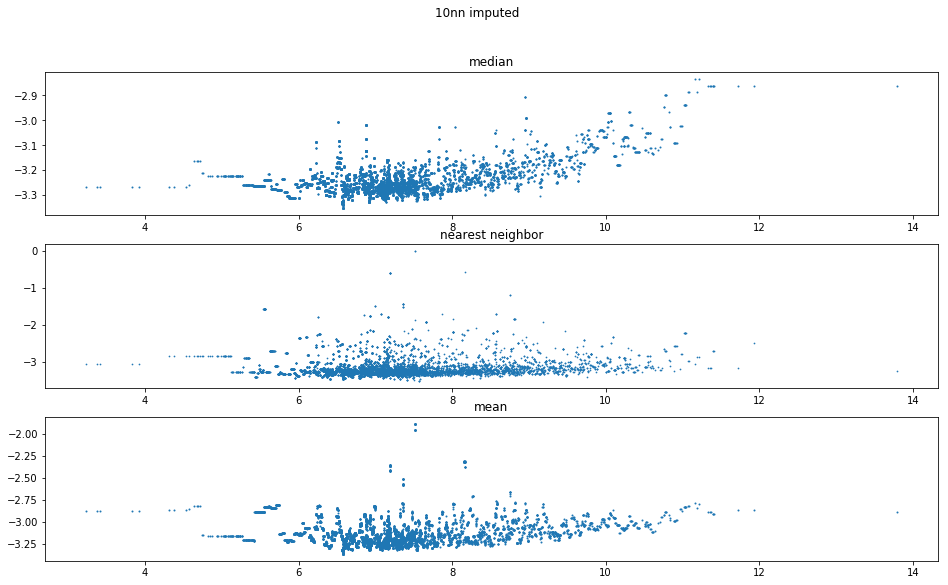

In [59]:
fig, (ax1, ax2, ax3)= plt.subplots(3, 1, figsize=(16, 9))
ax1.scatter(np.log(out_reset.surface_area), np.log(medians['median']), s=1)
brightnesses = out_reset.apply(lambda x: final_light[in_frame.loc[x["nearest_ix"][0]].BBL].mean(), axis=1)
ax2.scatter(np.log(out_reset.surface_area), np.log(brightnesses), s=.5)

ax3.scatter(np.log(out_reset.surface_area), np.log(means['mean']), s=1)


fig.suptitle("10nn imputed")
ax1.set_title("median")
ax2.set_title("nearest neighbor")
ax3.set_title("mean")

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Text(0.5,1,'mean')

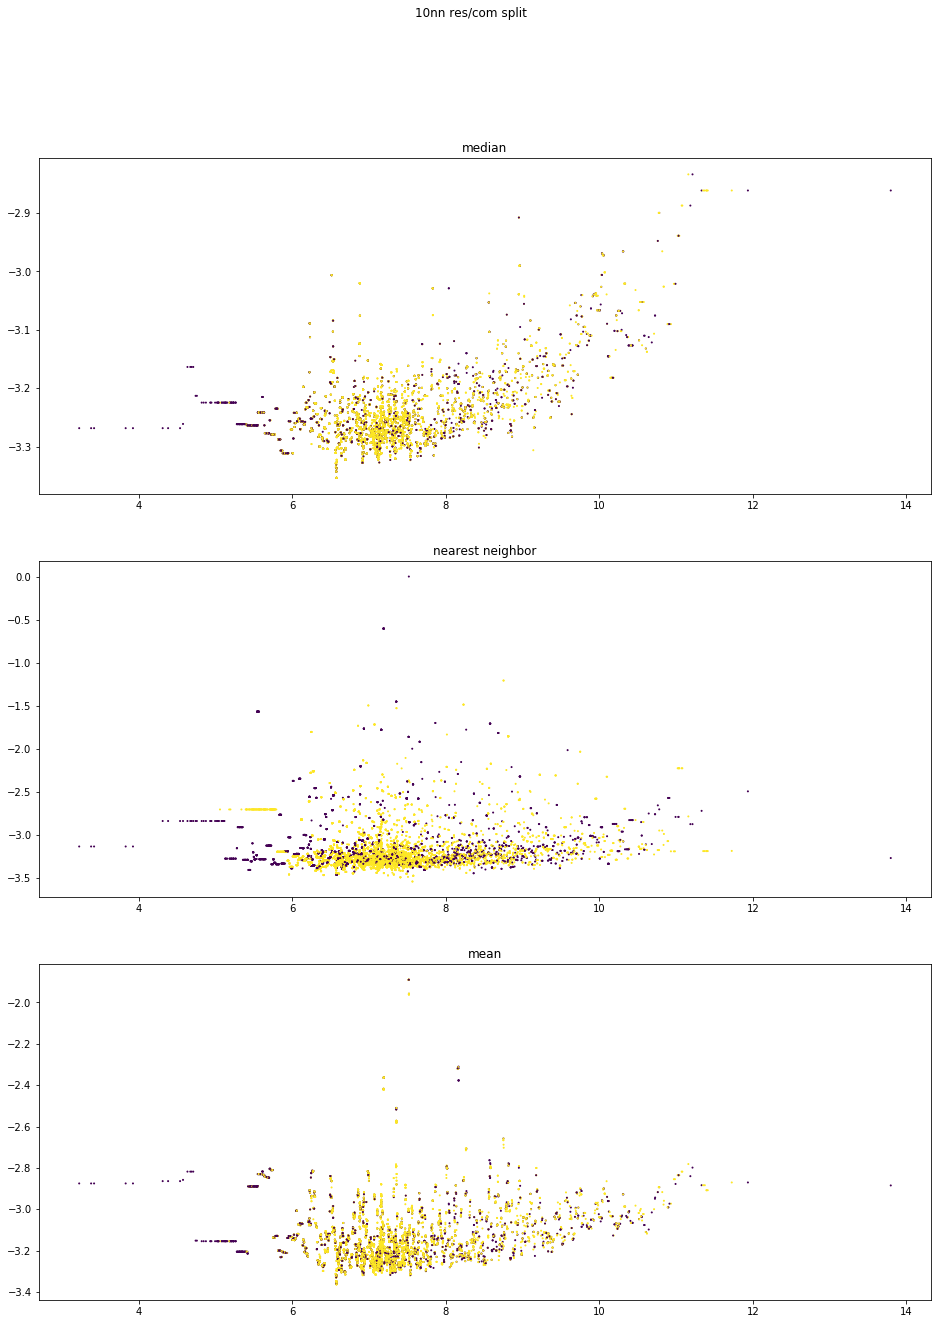

In [56]:
medians_rescom = []
means_rescom = []
for i, indices in enumerate(out_reset["nearest_ix"]):
    cbbl = in_frame.loc[indices].BBL
    median = final_light[cbbl].mean().median()
    mean = final_light[cbbl].mean().mean()
    medians_rescom.append((i, median))
    means_rescom.append((i, mean))

medians_rescom = np.array(medians_rescom, dtype=[('ix', int), ('median', np.float64)])
means_rescom = np.array(means_rescom, dtype=[('ix', int), ('mean', np.float64)])

fig, (ax1, ax2, ax3)= plt.subplots(3, 1, figsize=(16, 21))
ax1.scatter(np.log(out_reset.surface_area), np.log(medians_rescom['median']), s=1,
            c=out_reset.BldgClass.str[0].isin(RESIDENTIAL))
brightnesses = out_reset.apply(lambda x: final_light[in_frame.loc[x["nearest_ix_residential"][0]].BBL].mean(), 
                               axis=1)
ax2.scatter(np.log(out_reset.surface_area), np.log(brightnesses), s=1, 
            c=out_reset.BldgClass.str[0].isin(RESIDENTIAL))

ax3.scatter(np.log(out_reset.surface_area), np.log(means_rescom['mean']), s=1,
            c=out_reset.BldgClass.str[0].isin(RESIDENTIAL))

fig.suptitle("10nn res/com split")
ax1.set_title("median")
ax2.set_title("nearest neighbor")
ax3.set_title("mean")

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5,0.98,'in the frame')

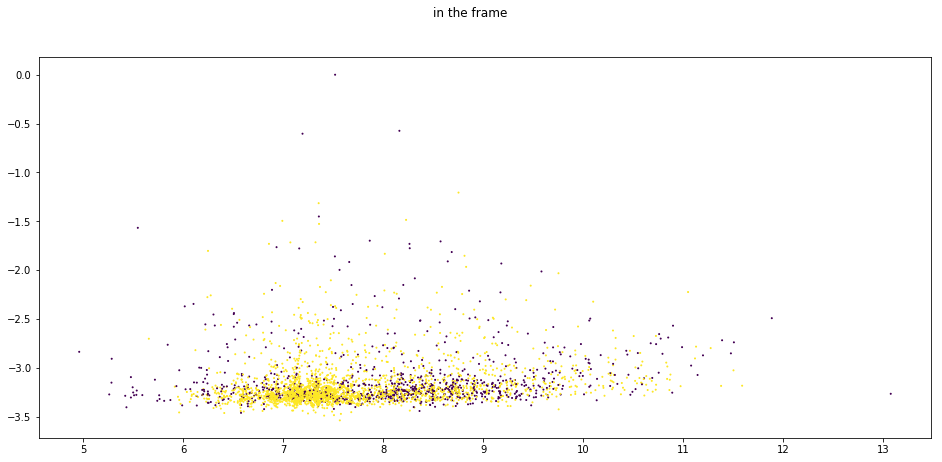

In [46]:
fig, (ax1)= plt.subplots(1, 1, figsize=(16, 7))
ax1.scatter(np.log(in_frame.surface_area), np.log(final_light[in_frame.BBL].mean()), s=1,
            c=in_frame.BldgClass.str[0].isin(RESIDENTIAL))
fig.suptitle("in the frame")
